In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.linear_model import LinearRegression

import analysis_utils as aute

In [2]:
rdm_th = 0
corr_th = 0.85

In [3]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".xlsx" in file][0]
    try:
        df_x = pd.read_excel(path_to_conversations + conv + "/" + excel_name)
        if df_x.shape[0] > 2:
            all_df_list.append(df_x)
    except:
        print("Bad file", conv + "/" + excel_name)
            
print("Number of conversations:", len(all_df_list))

Bad file Elena_20221005_112930.120/Conv_20221005_112930.120.xlsx
Number of conversations: 11


In [4]:
def include_time_columns(data, col_name):
    
    return {
        "Mean_" + col_name: np.nanmean(data[col_name]) if col_name in data.columns else np.nan,
        "Max_" + col_name: np.nanmax(data[col_name]) if col_name in data.columns else np.nan,
        "Min_" + col_name: np.nanmin(data[col_name]) if col_name in data.columns else np.nan,
        "Diff_" + col_name: (
            data[col_name].dropna().iloc[-1] - data[col_name].dropna().iloc[0] if col_name in data.columns else np.nan
        ),
    }

In [5]:
check_list = []
for df in all_df_list:
    
    dict_data = {
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["UnixTimestampEnd"].iloc[-1] - df["UnixTimestampInit"].iloc[0])/60,
    }
    
    dict_res = include_time_columns(df, "OpenAItime_s")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, "AWStime_s")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, "S2Ttime_s")
    dict_data.update(dict_res)
    
    check_list.append(dict_data)
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 19.1818 +/- 8.6426 ; Median = 15.0 ; Min. =  11 ; Max. =  38



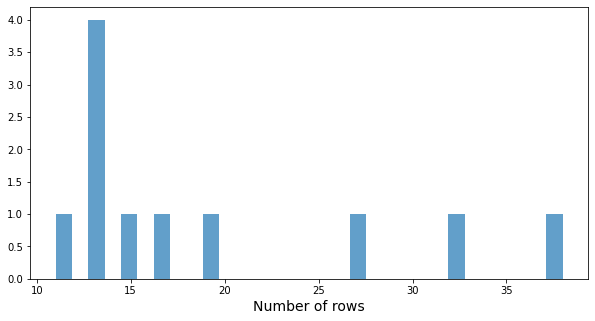

Mean Number of cols = 16.0 +/- 0.0 ; Median = 16.0 ; Min. =  16 ; Max. =  16

Mean Time conversation (min) = 3.6596 +/- 2.1589 ; Median = 2.7393 ; Min. =  1.7842 ; Max. =  8.8389



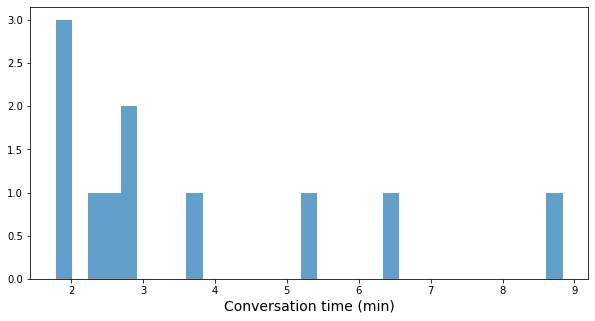

In [6]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.9882 +/- 0.5475 ; Median = 1.9766 ; Min. =  1.1579 ; Max. =  3.33
Mean Mean_AWStime_s = 0.127 +/- 0.0303 ; Median = 0.1199 ; Min. =  0.087 ; Max. =  0.1817
Mean Mean_S2Ttime_s = 1.5952 +/- 0.3088 ; Median = 1.4731 ; Min. =  1.2804 ; Max. =  2.1948


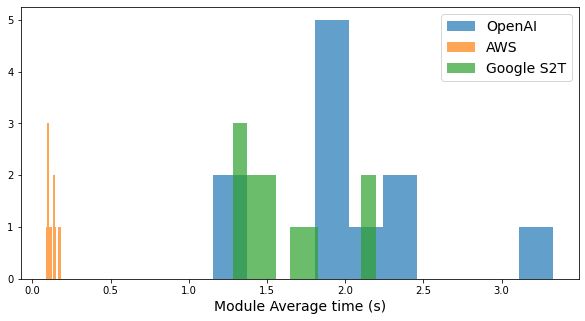

In [7]:
aute.stat_print(df_check["Mean_OpenAItime_s"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Mean_AWStime_s"], "Mean_AWStime_s")
aute.stat_print(df_check["Mean_S2Ttime_s"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Mean_OpenAItime_s"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Mean_AWStime_s"], alpha=0.7, label="AWS")
plt.hist(df_check["Mean_S2Ttime_s"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.8762 +/- 1.0615 ; Median = 1.6457 ; Min. =  0.6612 ; Max. =  4.6638
Mean Mean_AWStime_s = -0.2132 +/- 0.0633 ; Median = -0.2223 ; Min. =  -0.2633 ; Max. =  -0.0206
Mean Mean_S2Ttime_s = 0.6869 +/- 0.4316 ; Median = 0.3639 ; Min. =  0.3053 ; Max. =  1.5122


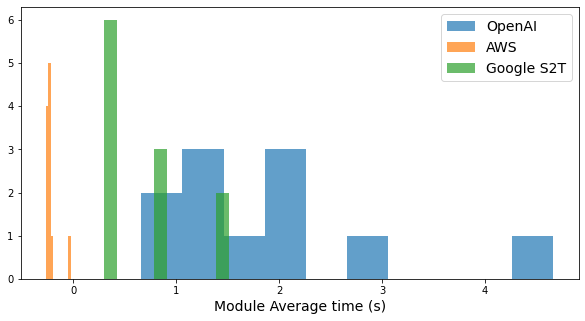

In [8]:
aute.stat_print(df_check["Diff_OpenAItime_s"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Diff_AWStime_s"], "Mean_AWStime_s")
aute.stat_print(df_check["Diff_S2Ttime_s"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Diff_OpenAItime_s"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Diff_AWStime_s"], alpha=0.7, label="AWS")
plt.hist(df_check["Diff_S2Ttime_s"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

In [9]:
save_time_dict = {
    "AWS_t": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "Google_S2T": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "OpenAI": {
        "num_words": [],
        "num_characters": [],
        "time": []
    }
}
for df in all_df_list:
    if "AWStime_s" in df.columns:
        for i in range(df.shape[0] // 2):
            bot_sentence = df[df["Source"]=="Bot"]["SpanishMessage"].iloc[i]
            num_all_words = len( "".join(re.findall(r'\w+', bot_sentence)) )
            save_time_dict["AWS_t"]["num_words"].append( num_all_words )
            save_time_dict["AWS_t"]["num_characters"].append( len(bot_sentence) )
            save_time_dict["AWS_t"]["time"].append( df[df["Source"]=="Person"]["AWStime_s"].iloc[i] )
    
    if "S2Ttime_s" in df.columns:
        df_person = df[df["Source"]=="Person"]
        for i in range(df_person.shape[0]):
            num_all_words = len( "".join(re.findall(r'\w+', df_person["SpanishMessage"].iloc[i])) )
            save_time_dict["Google_S2T"]["num_words"].append( num_all_words )
            save_time_dict["Google_S2T"]["num_characters"].append( len(df_person["SpanishMessage"].iloc[i]) )
            save_time_dict["Google_S2T"]["time"].append( df_person["S2Ttime_s"].iloc[i] )

    if "OpenAItime_s" in df.columns:
        df_bot = df[df["Source"]=="Bot"]
        for i in range(df_bot.shape[0]):
            num_all_words = len( "".join(re.findall(r'\w+', df_bot["GlobalMessage"].iloc[i])) )
            save_time_dict["OpenAI"]["num_words"].append( num_all_words )
            save_time_dict["OpenAI"]["num_characters"].append( len(df_bot["GlobalMessage"].iloc[i]) )
            save_time_dict["OpenAI"]["time"].append( df_bot["OpenAItime_s"].iloc[i] )


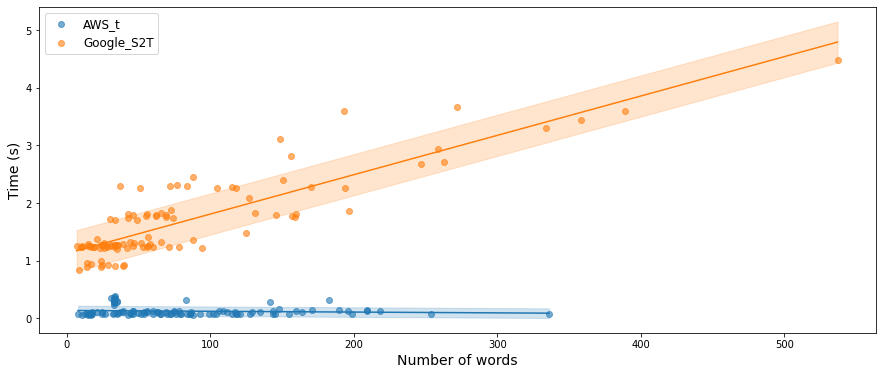

In [10]:
plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):
    
    if k is not "OpenAI":
    
        sort_x_idx = np.argsort(v["num_words"])
        y_time = np.array(v["time"])[sort_x_idx]
        x_len_text = np.array(v["num_words"])[sort_x_idx]

        x_to_lr = np.array(x_len_text).reshape(-1, 1)
        lr = LinearRegression(n_jobs=-1)
        lr.fit(x_to_lr, y_time)
        y_pred = lr.predict(x_to_lr)

        err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
        y_time_plus = y_pred + err_pred
        y_time_minus = y_pred - err_pred


        plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
        plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
        plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

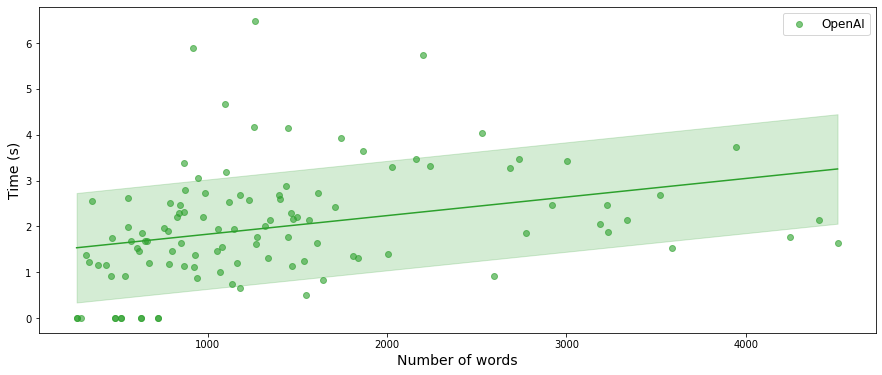

In [11]:
k = "OpenAI"
v = save_time_dict[k]

plt.figure(figsize=(15, 6))
    
sort_x_idx = np.argsort(v["num_words"])
y_time = np.array(v["time"])[sort_x_idx]
x_len_text = np.array(v["num_words"])[sort_x_idx]

x_to_lr = np.array(x_len_text).reshape(-1, 1)
lr = LinearRegression(n_jobs=-1)
lr.fit(x_to_lr, y_time)
y_pred = lr.predict(x_to_lr)

err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
y_time_plus = y_pred + err_pred
y_time_minus = y_pred - err_pred


plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

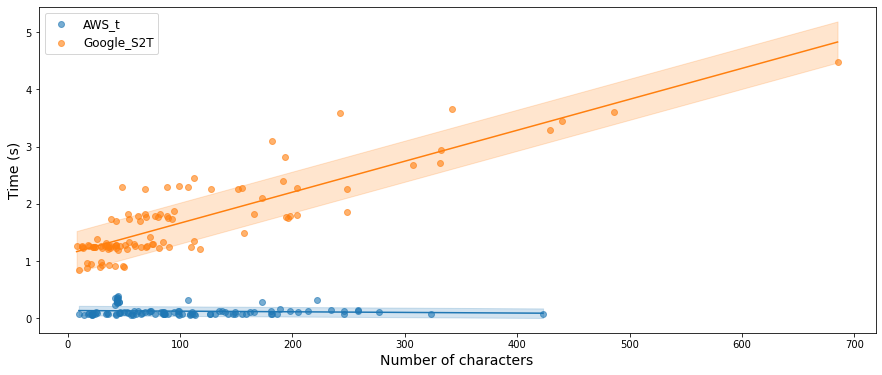

In [12]:
plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):
    
    if k is not "OpenAI":

        sort_x_idx = np.argsort(v["num_characters"])
        y_time = np.array(v["time"])[sort_x_idx]
        x_len_text = np.array(v["num_characters"])[sort_x_idx]

        x_to_lr = np.array(x_len_text).reshape(-1, 1)
        lr = LinearRegression(n_jobs=-1)
        lr.fit(x_to_lr, y_time)
        y_pred = lr.predict(x_to_lr)

        err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
        y_time_plus = y_pred + err_pred
        y_time_minus = y_pred - err_pred


        plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
        plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
        plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of characters", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

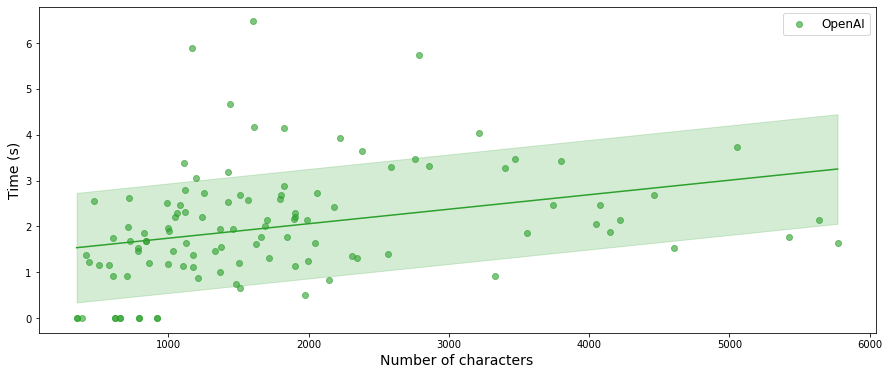

In [13]:
k = "OpenAI"
v = save_time_dict[k]

plt.figure(figsize=(15, 6))
    
sort_x_idx = np.argsort(v["num_characters"])
y_time = np.array(v["time"])[sort_x_idx]
x_len_text = np.array(v["num_characters"])[sort_x_idx]

x_to_lr = np.array(x_len_text).reshape(-1, 1)
lr = LinearRegression(n_jobs=-1)
lr.fit(x_to_lr, y_time)
y_pred = lr.predict(x_to_lr)

err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
y_time_plus = y_pred + err_pred
y_time_minus = y_pred - err_pred


plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of characters", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

In [72]:
resource_name_list = ["OpenAItime_s", "AWStime_s", "S2Ttime_s"]
save_time_list = []
counter = 0
for df in all_df_list:
    
    max_index_take = df[df["Source"] == "Bot"].index[-1]
    df_to_study = df.loc[1:(max_index_take+1)].reset_index(drop=True)

    n_iter = (df_to_study.shape[0] // 2) - 1

    for i in range(n_iter):
        t_per_end_talk = df_to_study["UnixTimestampEnd"].iloc[2*i]
        t_bot_end_talk = df_to_study["UnixTimestampEnd"].iloc[2*i+1]

        delta_t_aws = df_to_study["AWStime_s"].iloc[2*i+2]
        delta_t_s2t = df_to_study["S2Ttime_s"].iloc[2*i+2]
        delta_t_openai = df_to_study["OpenAItime_s"].iloc[2*i+1]

        total_time = (t_bot_end_talk - t_per_end_talk) + delta_t_aws + delta_t_s2t
        rest_time = total_time - delta_t_aws - delta_t_s2t - delta_t_openai

        # print(rest_time, total_time, delta_t_aws, delta_t_s2t, delta_t_openai)

        save_time_list += [
            {
                "Iteration": counter,
                "Source": "AWS",
                "Time": delta_t_aws
            }, 
            {
                "Iteration": counter,
                "Source": "S2T",
                "Time": delta_t_s2t
            }, 
            {
                "Iteration": counter,
                "Source": "OpenAI",
                "Time": delta_t_openai
            }, 
            {
                "Iteration": counter,
                "Source": "Total",
                "Time": total_time
            }, 
            {
                "Iteration": counter,
                "Source": "Rest",
                "Time": rest_time
            }
        ]

        counter += 1
        
df_times = pd.DataFrame(save_time_list)
print("Shape", df_times.shape)

Shape (440, 3)


In [108]:
all_times_list = []
for g, df_g in df_times.groupby("Iteration"):
    dict_times = dict(zip(df_g["Source"].values.tolist(), df_g["Time"].values.tolist()))
    all_times_list.append(dict_times)
df_all_t_sources = pd.DataFrame(all_times_list)

df_all_t_sources.to_csv("SaveToBoxplot.csv", index=False)

In [107]:
df_all_t_sources["Total"] - np.sum(df_all_t_sources[["Rest", "OpenAI", "S2T", "AWS"]], axis=1)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
83    0.0
84    0.0
85    0.0
86    0.0
87    0.0
Length: 88, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


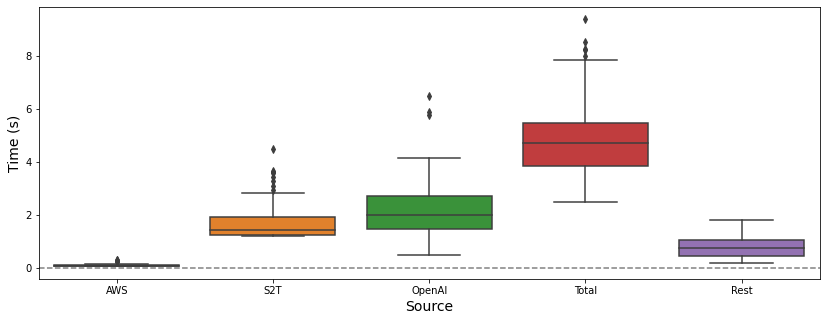

In [109]:
plt.figure(figsize=(14, 5))
sns.boxplot(x="Source", y="Time", data=df_times)

plt.axhline(0, c="black", linestyle="--", alpha=0.5)

plt.xlabel("Source", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.savefig('../Documents/Images/save_boxplot.eps', format='eps')
plt.savefig('../Documents/Images/save_boxplot_svg.svg', format='svg', dpi=1200)

plt.show()